In [1]:
%load_ext lab_black
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
import os
import string

np.random.seed(1234)

plt.rcParams["font.family"] = ["Liberation Sans"]

In [2]:
df_lanc = pd.read_excel("../02-region-locus-simulate/results/lanc-pitfall-het.xlsx")
df_lanc = df_lanc.iloc[5:10, 1:].set_index("effect_ratio")

# Part 1: heterogeneity as a function of local ancestry

In [3]:
def get_mean_sem(text: np.ndarray):
    """
    Parse mean and sem from a text array [mean (sem), ...,]
    """
    mean = np.array([float(f.split("(")[0]) for f in text])
    sem = np.array([float(f.split("(")[1].strip(")")) for f in text])
    return mean, sem

In [4]:
def plot_het_lanc(df_lanc, axes):

    # heterogeneity statistics
    for i, method in enumerate(df_lanc.columns):
        tmp_mean, tmp_sem = get_mean_sem(df_lanc[method])
        # false positives
        axes[0].errorbar(
            x=(i - 1) * 0.15,
            y=tmp_mean[0],
            yerr=tmp_sem[0] * 1.96,
            fmt=".",
            lw=0.75,
            label=method,
        )

        if i != 2:
            # power
            axes[1].errorbar(
                x=np.arange(len(tmp_mean[1:])) + (i - 0.5) * 0.15,
                y=tmp_mean[1:],
                yerr=tmp_sem[1:] * 1.96,
                fmt=".",
                lw=0.75,
                label=method,
            )

    # false positives
    axes[0].set_xticks([0])
    axes[0].set_xticklabels([1.0], fontsize=9)
    axes[0].set_ylim(0, 0.25)
    axes[0].set_xlim(-0.5, 0.5)
    axes[0].axhline(y=0.05, ls="--", color="red", alpha=0.5, lw=0.8)
    axes[0].set_ylabel("False positive rate")

    # power
    axes[1].set_xticks(np.arange(len(tmp_mean) - 1))
    axes[1].set_xlim(-0.5, len(tmp_mean) - 1.5)
    axes[1].set_xticklabels(df_lanc.index[1:], fontsize=9)
    axes[1].set_ylim(0, 0.25)
    axes[1].axhline(y=0.05, ls="--", color="red", alpha=0.5, lw=0.8)
    axes[1].set_ylabel("Power")

    for i, ax in enumerate(axes):
        ax.text(
            -0.12,
            0.98,
            string.ascii_lowercase[i],
            transform=ax.transAxes,
            size=12,
            weight="bold",
        )

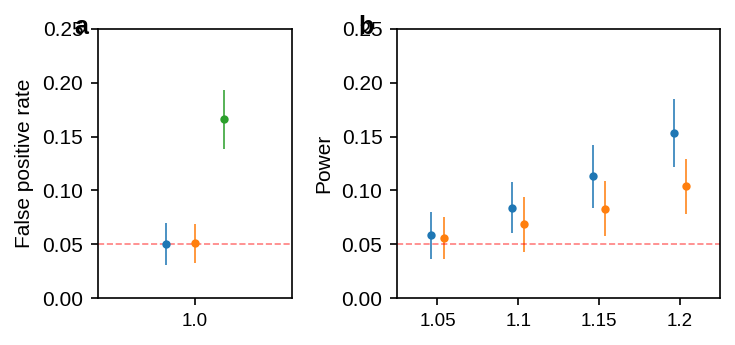

In [5]:
fig, axes = plt.subplots(
    figsize=(5, 2.4), ncols=2, gridspec_kw={"width_ratios": [1.8, 3]}, dpi=150
)
plot_het_lanc(df_lanc, axes)

fig.tight_layout()

# Part 2: simulation with single causal variant

In [6]:
df_single = pd.read_csv(
    "../02-region-locus-simulate/results/single-causal-simulation.tsv",
    sep="\t",
)

In [7]:
def plot_single_causal(df_single, axes):
    colors = ["#e41a1c", "#377eb8"]
    for group_i, group in enumerate(["Causal", "Clumped (all)"]):
        df_group = df_single[df_single.group == group]

        for metric_i, metric in enumerate(["HET FPR", "Deming (EUR$\sim$AFR)"]):
            ax = axes[metric_i]
            if metric_i == 0:
                label = group.split("(")[0]
            else:
                label = None

            hsq_list = ["0.2%", "0.6%", "1.0%"]
            metric_mean, metric_sem = get_mean_sem(df_group[metric])
            ax.errorbar(
                np.arange(len(hsq_list)) - 0.1 + 0.2 * group_i,
                metric_mean,
                yerr=metric_sem * 1.96,
                fmt=".",
                ms=5,
                mew=1,
                label=label,
                linewidth=1,
                color=colors[group_i],
            )

            hline = [0.05, 1.0][metric_i]
            ylabel = ["HET FPR", "Deming slope"][metric_i]
            ylim = [[0, 0.35], [0.85, 1.15]][metric_i]
            ax.axhline(y=hline, color="black", ls="--", alpha=0.3)
            ax.set_xticks(np.arange(len(hsq_list)))
            ax.set_xticklabels(hsq_list)
            ax.set_xlim(-0.5, len(hsq_list) - 0.5)

            ax.set_ylabel(ylabel, fontsize=9)
            ax.set_ylim(ylim)

    for i, ax in enumerate(axes):
        ax.text(
            -0.2,
            1.06,
            string.ascii_lowercase[i],
            transform=ax.transAxes,
            size=12,
            weight="bold",
        )

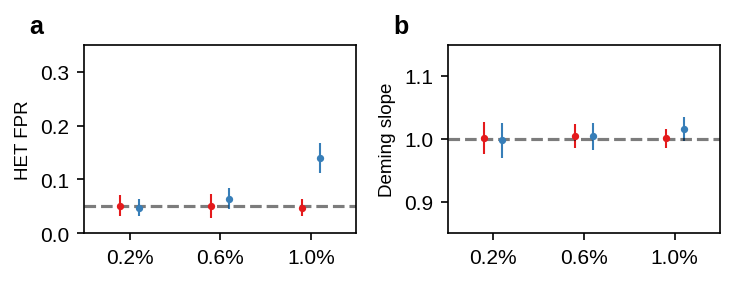

In [8]:
fig, axes = plt.subplots(figsize=(5, 2), ncols=2, dpi=150)
plot_single_causal(df_single, axes)
fig.tight_layout()

# Part 3: multiple causal

In [9]:
df_multiple = []
for group in ["causal", "clump"]:
    df = pd.read_csv(
        f"../02-chrom-locus-simulate/results/multiple-causal.{group}.tsv", sep="\t"
    )
    df = df[df.hsq == "10\%"].drop(columns=["hsq"])
    df.insert(0, "group", group)
    df_multiple.append(df)
df_multiple = pd.concat(df_multiple, axis=0)

In [10]:
def plot_multiple_causal(df, axes):
    colors = ["#e41a1c", "#377eb8"]

    for group_i, group in enumerate(["causal", "clump"]):
        df_group = df[df.group == group]

        for metric_i, metric in enumerate(["HET FPR", "Deming (EUR$\sim$AFR)"]):
            ax = axes[metric_i]
            if metric_i == 0:
                label = ["Causal", "Clumped"][group_i]
            else:
                label = None

            ncausal_list = df_group["ncausal"]
            metric_mean, metric_sem = get_mean_sem(df_group[metric])
            ax.errorbar(
                np.arange(len(ncausal_list)) - 0.1 + 0.2 * group_i,
                metric_mean,
                yerr=metric_sem * 1.96,
                fmt=".",
                ms=5,
                mew=1,
                label=label,
                linewidth=1,
                color=colors[group_i],
            )

            hline = [0.05, 1.0][metric_i]
            ylabel = ["HET FPR", "Deming slope"][metric_i]
            ylim = [[0, 0.35], [0.85, 1.15]][metric_i]
            ax.axhline(y=hline, color="black", ls="--", alpha=0.3)
            ax.set_xticks(np.arange(len(ncausal_list)))
            ax.set_xticklabels([0.25, 0.5, 1.0, 2.0, 4.0], fontsize=9)
            ax.set_xlim(-0.5, len(ncausal_list) - 0.5)

            ax.set_ylabel(ylabel, fontsize=9)
            ax.set_ylim(ylim)

    for i, ax in enumerate(axes):
        ax.text(
            -0.2,
            1.06,
            string.ascii_lowercase[i + 2],
            transform=ax.transAxes,
            size=12,
            weight="bold",
        )

In [11]:
def add_legend(fig, axes, y, x=0.5):
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        ncol=len(handles),
        loc="center",
        bbox_to_anchor=[x, y],
        frameon=False,
        fontsize=9,
        handletextpad=0.02,
    )

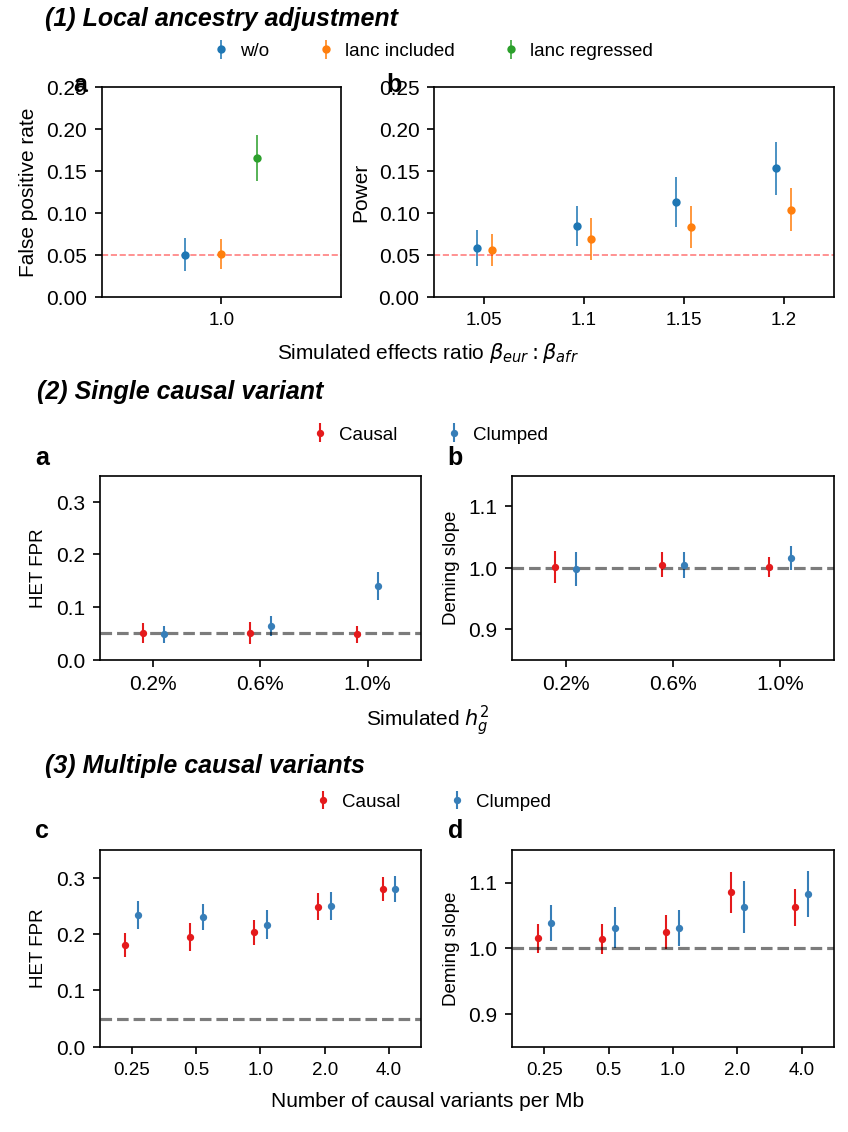

In [12]:
fig = plt.figure(dpi=150, figsize=(5.5, 7), constrained_layout=True)
# trick
fig.suptitle(" ", y=1.05)

subfigs = fig.subfigures(nrows=3, ncols=1)

## HET lanc
axes = subfigs[0].subplots(nrows=1, ncols=2, gridspec_kw={"width_ratios": [1.8, 3]})
plot_het_lanc(df_lanc, axes)
subfigs[0].supxlabel(
    r"Simulated effects ratio $\beta_{eur} : \beta_{afr}$", fontsize=10
)
subfigs[0].suptitle(
    "(1) Local ancestry adjustment",
    x=0.25,
    y=1.2,
    fontweight="bold",
    style="italic",
)
add_legend(fig, axes, y=1.015)

## single causal
axes = subfigs[1].subplots(nrows=1, ncols=2)
plot_single_causal(df_single, axes)
subfigs[1].supxlabel("Simulated $h_g^2$", fontsize=10)
subfigs[1].suptitle(
    "(2) Single causal variant",
    x=0.2,
    y=1.2,
    fontweight="bold",
    style="italic",
)

add_legend(fig, axes, y=0.65)


## multiple causals
axes = subfigs[2].subplots(nrows=1, ncols=2)
plot_multiple_causal(df_multiple, axes)
subfigs[2].supxlabel("Number of causal variants per Mb", fontsize=10)
subfigs[2].suptitle("Multiple causal variants")
subfigs[2].suptitle(
    "(3) Multiple causal variants",
    x=0.23,
    y=1.2,
    fontweight="bold",
    style="italic",
)
add_legend(fig, axes, y=0.3)

fig.set_constrained_layout_pads(hspace=0.2)
fig.savefig("results.pdf", bbox_inches="tight")

# Separate

# Local ancestry adjustment

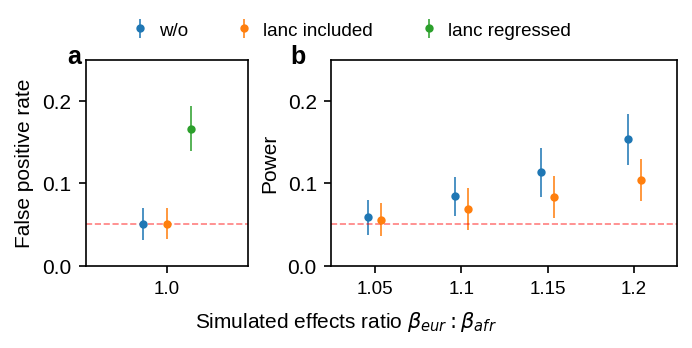

In [13]:
fig, axes = plt.subplots(
    dpi=150,
    figsize=(4.5, 2),
    ncols=2,
    gridspec_kw={"width_ratios": [1.4, 3]},
    constrained_layout=True,
)

## HET lanc
plot_het_lanc(df_lanc, axes)
fig.supxlabel(r"Simulated effects ratio $\beta_{eur} : \beta_{afr}$", fontsize=10)
# fig.suptitle(
#     "Local ancestry adjustment",
#     x=0.25,
#     y=1.2,
#     fontweight="bold",
#     style="italic",
# )
add_legend(fig, axes, y=1.03)
fig.savefig("lanc-pitfall.pdf", bbox_inches="tight")

# Single causal and multiple causals

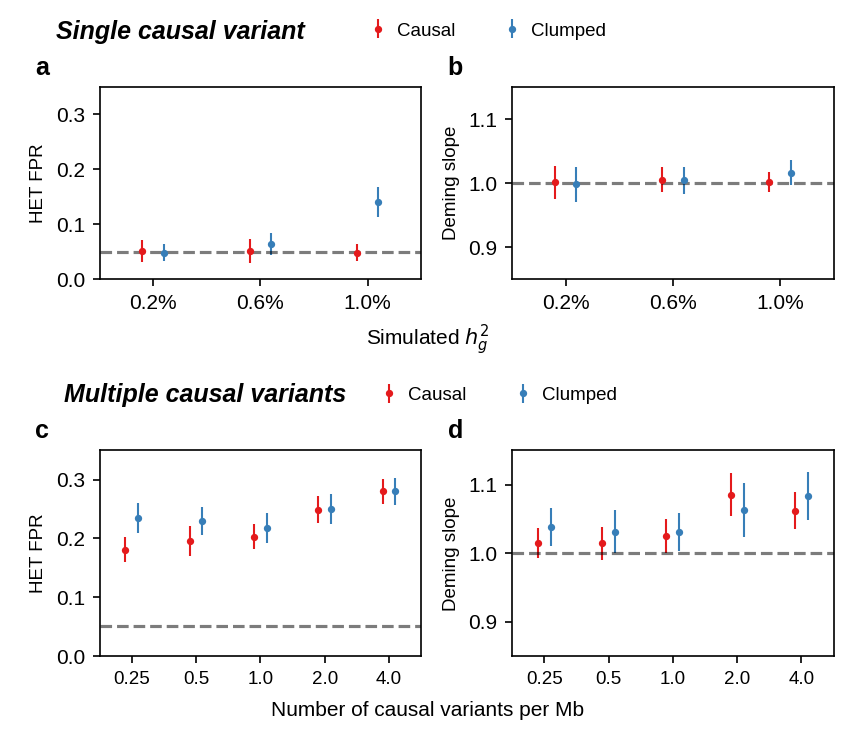

In [14]:
fig = plt.figure(dpi=150, figsize=(5.5, 4.5), constrained_layout=True)
# trick
fig.suptitle(" ", y=1.05)

subfigs = fig.subfigures(nrows=2, ncols=1)

## single causal
axes = subfigs[0].subplots(nrows=1, ncols=2)
plot_single_causal(df_single, axes)
subfigs[0].supxlabel("Simulated $h_g^2$", fontsize=10)
subfigs[0].suptitle(
    "Single causal variant",
    x=0.2,
    y=1.1,
    fontweight="bold",
    style="italic",
)

add_legend(fig, axes, y=1.03, x=0.57)


## multiple causals
axes = subfigs[1].subplots(nrows=1, ncols=2)
plot_multiple_causal(df_multiple, axes)
subfigs[1].supxlabel("Number of causal variants per Mb", fontsize=10)
subfigs[1].suptitle("Multiple causal variants")
subfigs[1].suptitle(
    "Multiple causal variants",
    x=0.23,
    y=1.1,
    fontweight="bold",
    style="italic",
)
add_legend(fig, axes, y=0.49, x=0.58)

fig.set_constrained_layout_pads(hspace=0.15)
fig.savefig("het-deming.pdf", bbox_inches="tight")